         Date       Open       High        Low      Close  Adj Close  \
0  2014-01-02  19.845715  19.893929  19.715000  19.754642  17.296652   
1  2014-01-03  19.745001  19.775000  19.301071  19.320715  16.916719   
2  2014-01-06  19.194643  19.528570  19.057142  19.426071  17.008968   
3  2014-01-07  19.440001  19.498571  19.211430  19.287144  16.887323   
4  2014-01-08  19.243214  19.484285  19.238930  19.409286  16.994270   

      Volume  
0  234684800  
1  392467600  
2  412610800  
3  317209200  
4  258529600  
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0914 - val_loss: 0.0166
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0140
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - val_loss: 0.0140
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - val_loss: 0.0140
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0138
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0138
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0137
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0138
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - val_loss: 0.0139
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0139
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0138
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - 

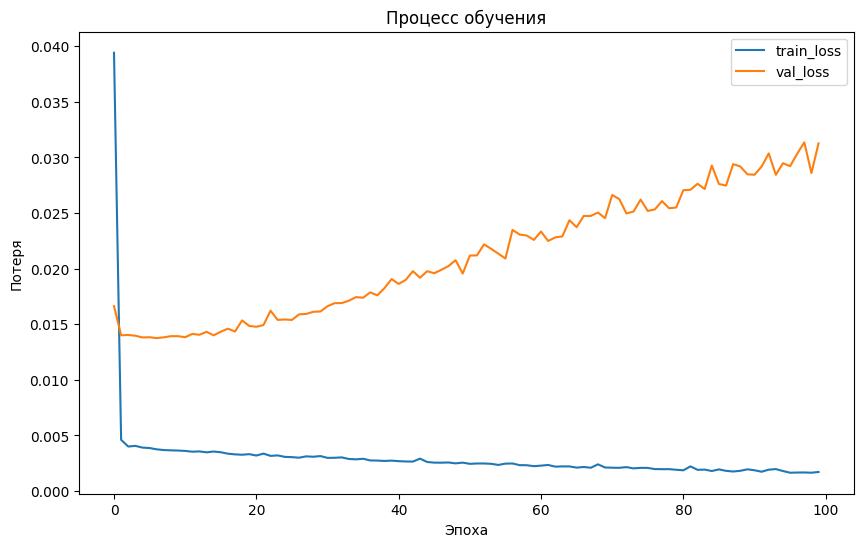

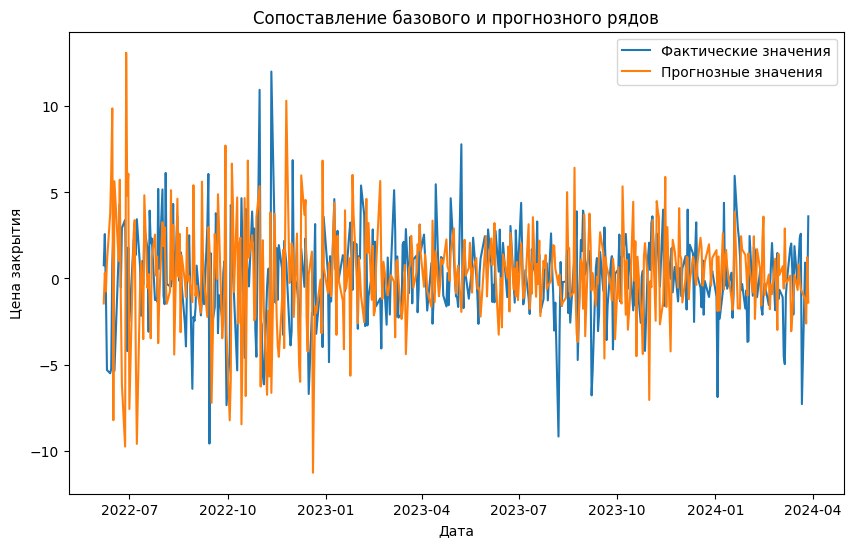

<Figure size 1000x600 with 0 Axes>

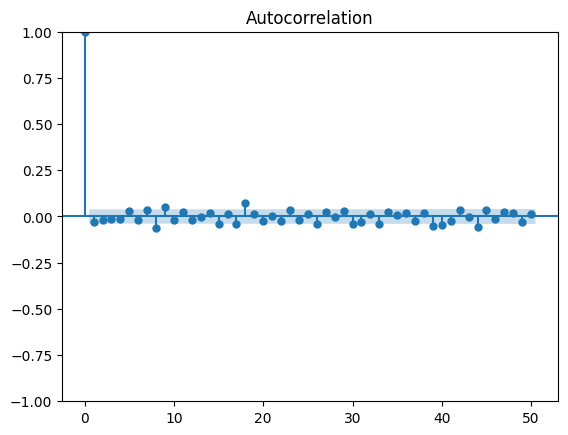

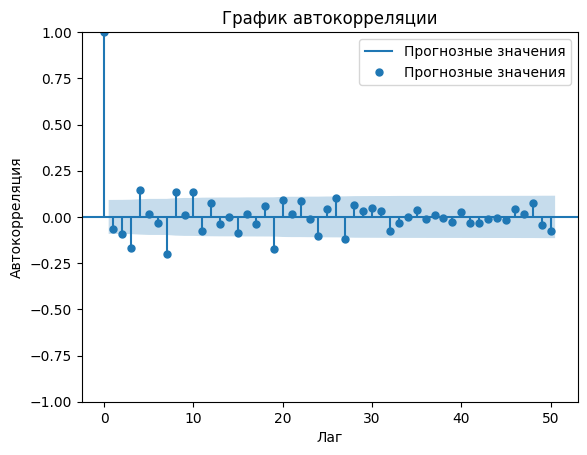

In [ ]:
#
# Решение
# Установка необходимых библиотек
!pip install tensorflow pandas matplotlib statsmodels

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Загрузка датасета
url = "https://storage.yandexcloud.net/academy.ai/AAPL.csv"
df = pd.read_csv(url)

# Просмотр первых строк датасета
print(df.head())

# Преобразование даты в формат datetime
df['Date'] = pd.to_datetime(df['Date'])

# Удаление строк с пропущенными значениями
df = df.dropna()

# Дифференцирование для удаления тренда
df['Close_diff'] = df['Close'].diff()

# Удаление первой строки с NaN после дифференцирования
df = df.dropna()

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_diff_scaled'] = scaler.fit_transform(df['Close_diff'].values.reshape(-1, 1))

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Создание временных рядов
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train['Close_diff_scaled'].values.reshape(-1, 1), time_step)
X_test, y_test = create_dataset(test['Close_diff_scaled'].values.reshape(-1, 1), time_step)

# Преобразование в трехмерный формат для Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Создание модели
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Предсказание на тестовой выборке
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное преобразование для восстановления исходных значений
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Вычисление среднеквадратической ошибки (MSE)
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(f"Среднеквадратическая ошибка (MSE) на обучающей выборке: {train_mse}")
print(f"Среднеквадратическая ошибка (MSE) на тестовой выборке: {test_mse}")

# График процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Процесс обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.show()

# График сопоставления базового и прогнозного рядов
plt.figure(figsize=(10, 6))
plt.plot(test['Date'].iloc[time_step+1:], y_test, label='Фактические значения')
plt.plot(test['Date'].iloc[time_step+1:], test_predict, label='Прогнозные значения')
plt.title('Сопоставление базового и прогнозного рядов')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.show()

# График автокорреляции
plt.figure(figsize=(10, 6))
plot_acf(df['Close_diff'].dropna(), lags=50, label='Фактические значения')
plot_acf(test_predict.flatten(), lags=50, label='Прогнозные значения')
plt.title('График автокорреляции')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.legend()
plt.show()